# Assignment 2
# Rishika Tibrewal, MDS202135

## Importing Libraries

In [1]:
import gc
import json
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from numpy.linalg import norm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.preprocessing import normalize

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

## Importing Original Corpus

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with open("/content/drive/MyDrive/corpora.txt", "r") as f:
    content = f.readlines()

In [ ]:
content[0]

'introduction severe acute respiratory syndrome coronavirus is responsible for the outbreak of coronavirus disease the numbers are continuously evolving worldwide about million confirmed cases and deaths as of th may and italy has registered a huge number of cases and deaths as compared to other countries lung and systemic inflammation are the most common features of which may lead to multiorgan dysfunction and death hence extensive research in multiple therapeutic areas is rapidly progressing airborne particulate matter pm also called particle pollution is considered to be the most relevant component of air pollution pm is a heterogeneous mixture of solid and liquid organic and inorganic material suspended in air the characteristics and sources of ultrafine pm pm mm fine pm pm mm and coarse pm pm mm are described elsewhere numerous studies have documented the detrimental impact of pm air pollution on several organs particularly airways and lungs although the quality of evidence remain

In [ ]:
content = list(map(lambda text: text.strip(), content)) # removing \n from corpus 

## Lemmatizing Corpus and vocabulary

A copy of the corpus has been created and lemmatized for creating cooccurrence matrix. The vocabulary hence contains lemmatized words. Stopwords have been removed from the vocabulary.

In [ ]:
def lemma_vocab(corp):
  count=Counter()
  for i in tqdm(range(len(corp))):
    word_list=corp[i].split()
    word_list = list(map(lambda text: lemmatizer.lemmatize(text,pos="v"),word_list)) 
    corp[i]=" ".join(word_list)
    for j in range(len(word_list)):
      if word_list[j] not in stop_words:
        count.update([word_list[j]])
      else:
        continue
  return corp,count

In [ ]:
updated_corp,vocab=lemma_vocab(content)

100%|██████████| 50000/50000 [1:01:02<00:00, 13.65it/s]


In [ ]:
updated_corp[0]

'introduction severe acute respiratory syndrome coronavirus be responsible for the outbreak of coronavirus disease the number be continuously evolve worldwide about million confirm case and deaths as of th may and italy have register a huge number of case and deaths as compare to other countries lung and systemic inflammation be the most common feature of which may lead to multiorgan dysfunction and death hence extensive research in multiple therapeutic areas be rapidly progress airborne particulate matter pm also call particle pollution be consider to be the most relevant component of air pollution pm be a heterogeneous mixture of solid and liquid organic and inorganic material suspend in air the characteristics and source of ultrafine pm pm mm fine pm pm mm and coarse pm pm mm be describe elsewhere numerous study have document the detrimental impact of pm air pollution on several organs particularly airways and lungs although the quality of evidence remain poor in some case the exist

In [ ]:
len(vocab)

1636760

The words in the vocabulary is being reduced by considering only those words which occur more than 20 times in the entire corpus, i.e, 50000 documents. Moreover, the words which are just alphabets like, 'p', 'l', etc. are being removed from vocabulary.

In [ ]:
up_vocab={}
for word in vocab.keys():
  if len(word)!=1 and vocab[word]>20:
    up_vocab[word]=vocab[word]

In [ ]:
len(up_vocab)

98376

In [ ]:
with open("/content/drive/MyDrive/vocab.txt", "w") as f:
     f.write(json.dumps(up_vocab))

In [ ]:
corpora = "\n".join(updated_corp)
with open("/content/drive/MyDrive/lemmatized_corpus.txt", "w") as f:
    f.write(corpora)

## Importing lemmatized corpus and vocabulary

In [ ]:
vocab = dict(json.loads(Path("/content/drive/MyDrive/vocab.txt").read_text()))

The top 14000 words i.e, the 14000 most frequent words, are being chosen from the vocabulary. 

In [ ]:
with open("/content/drive/MyDrive/vocab_14k.txt", "w") as f:
     f.write(json.dumps(sorted(vocab.items(), key=lambda x:x[1], reverse=True)[:14000]))

Importing the vocabulary of 14000 words from drive.

In [5]:
vocab_14 = dict(json.loads(Path("/content/drive/MyDrive/vocab_14k.txt").read_text()))

Importing the lemmatized corpus from drive.

In [ ]:
with open("/content/drive/MyDrive/lemmatized_corpus.txt", "r") as f:
    text = f.readlines()

In [ ]:
text = list(map(lambda txt: txt.strip(), text)) # removing '\n' from corpus 

## Creating Co-occurrence matrix

vocab_idx is a dictionary where each key is a word in the vocabulary and value is the index we are assigning to that word while creating co-occurence matrix.

In [6]:
vocab_idx={word: end for end,word in enumerate(vocab_14)}

In [ ]:
def hal_matrix(corp, vocab):
  dim=len(vocab.keys())
  hal_l2r=np.zeros((dim,dim),np.float32)
  hal_r2l=np.zeros((dim,dim), np.float32)
  ramp = [0,10,9,8,7,6,5,4,3,2,1]
  rev_ramp=ramp[::-1]
  for i in tqdm(range(len(corp))):
    padded= '<s> '*10+corp[i]+' </s>'*10 # padding
    tokens=padded.split()
  
    for j in range(9,len(tokens)):
      if tokens[j] in vocab.keys():
        gram11=tokens[j:j+11]
        for k in range(11):
          if gram11[k] in vocab.keys():
            hal_l2r[vocab_idx[tokens[j]],vocab_idx[gram11[k]]]+=ramp[k]

    for j in range(0,len(tokens)-10):
      if tokens[j+10] in vocab.keys():
        gram11=tokens[j:j+11]
        for k in range(11):
          if gram11[k] in vocab.keys():
            hal_r2l[vocab_idx[tokens[j+10]],vocab_idx[gram11[k]]]+=rev_ramp[k]

  return hal_l2r,hal_r2l

In [ ]:
l,r=hal_matrix(text,vocab_14)

100%|██████████| 50000/50000 [3:27:12<00:00,  4.02it/s]


Dumping the created HAL matrices to drive.

In [ ]:
np.save('/content/drive/MyDrive/hal_l2r.npy', l)
np.save('/content/drive/MyDrive/hal_r2l.npy', r)

In [ ]:
print('The matrix (left to right filling): ',l.shape,'\n')
l

The matrix (left to right filling):  (14000, 14000) 



array([[1.66648e+05, 1.03089e+05, 1.58814e+05, ..., 0.00000e+00,
        1.06000e+02, 1.79000e+02],
       [8.69540e+04, 3.38226e+05, 1.35258e+05, ..., 0.00000e+00,
        1.89000e+02, 5.60000e+01],
       [2.25372e+05, 2.23615e+05, 1.72897e+05, ..., 0.00000e+00,
        7.50000e+01, 8.80000e+01],
       ...,
       [3.00000e+00, 0.00000e+00, 0.00000e+00, ..., 6.10000e+01,
        0.00000e+00, 0.00000e+00],
       [1.69000e+02, 1.29000e+02, 8.60000e+01, ..., 0.00000e+00,
        1.32000e+02, 0.00000e+00],
       [1.26000e+02, 6.90000e+01, 4.20000e+01, ..., 0.00000e+00,
        0.00000e+00, 2.67000e+02]], dtype=float32)

In [ ]:
print('The matrix (right to left filling): ',r.shape,'\n')
r

The matrix (right to left filling):  (14000, 14000) 



array([[1.66648e+05, 8.69540e+04, 2.25372e+05, ..., 3.00000e+00,
        1.69000e+02, 1.26000e+02],
       [1.03089e+05, 3.38226e+05, 2.23615e+05, ..., 0.00000e+00,
        1.29000e+02, 6.90000e+01],
       [1.58814e+05, 1.35258e+05, 1.72897e+05, ..., 0.00000e+00,
        8.60000e+01, 4.20000e+01],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 6.10000e+01,
        0.00000e+00, 0.00000e+00],
       [1.06000e+02, 1.89000e+02, 7.50000e+01, ..., 0.00000e+00,
        1.32000e+02, 0.00000e+00],
       [1.79000e+02, 5.60000e+01, 8.80000e+01, ..., 0.00000e+00,
        0.00000e+00, 2.67000e+02]], dtype=float32)

Concatenating both the matrices, i.e, each row is now a vector for a word in the vocabulary.

In [ ]:
hal_mat= np.concatenate((l,r), axis=1)
np.save('/content/drive/MyDrive/hal.npy', hal_mat)

In [7]:
cooc_matrix=np.load('/content/drive/MyDrive/hal.npy')

Normalising the co-occurence matrix

In [8]:
normed_matrix=normalize(cooc_matrix,axis=1)

In [9]:
normed_matrix.shape

(14000, 28000)

## Creating word vectors

Performing PCA on the normalised matrix to reduce the number of columns from 28000 to 300.

In [10]:
pca = decomposition.PCA(n_components=300)
trans_mat=pca.fit_transform(normed_matrix)

In [11]:
trans_mat.shape

(14000, 300)

In [12]:
np.save('/content/drive/MyDrive/PCA_matrix.npy', trans_mat)

In [13]:
pca_mat=np.load('/content/drive/MyDrive/PCA_matrix.npy')

In [14]:
pca_mat.shape

(14000, 300)

In [15]:
vocab_idx

{'use': 0,
 'patients': 1,
 'study': 2,
 'et': 3,
 'al': 4,
 'cells': 5,
 'also': 6,
 'may': 7,
 'show': 8,
 'result': 9,
 'case': 10,
 'data': 11,
 'include': 12,
 'virus': 13,
 'infection': 14,
 'increase': 15,
 'disease': 16,
 'test': 17,
 'model': 18,
 'time': 19,
 'report': 20,
 'find': 21,
 'group': 22,
 'one': 23,
 'level': 24,
 'number': 25,
 'health': 26,
 'viral': 27,
 'two': 28,
 'cell': 29,
 'however': 30,
 'protein': 31,
 'effect': 32,
 'control': 33,
 'sample': 34,
 'different': 35,
 'clinical': 36,
 'risk': 37,
 'fig': 38,
 'treatment': 39,
 'follow': 40,
 'de': 41,
 'figure': 42,
 'provide': 43,
 'could': 44,
 'analysis': 45,
 'present': 46,
 'high': 47,
 'compare': 48,
 'human': 49,
 'first': 50,
 'table': 51,
 'change': 52,
 'associate': 53,
 'base': 54,
 'sequence': 55,
 'factor': 56,
 'respiratory': 57,
 'identify': 58,
 'infect': 59,
 'well': 60,
 'need': 61,
 'suggest': 62,
 'system': 63,
 'value': 64,
 'make': 65,
 'perform': 66,
 'reduce': 67,
 'develop': 68,
 '

## Finding 10 most similar words and plotting the graph

Using cosine similarity as the measure of similarity between 2 word vectors.

In [16]:
def similarity(noun):
  i=vocab_idx[noun]
  similar={}
  for word in vocab_14.keys():
    j= vocab_idx[word]
    similar[word]= np.dot(pca_mat[i],pca_mat[j])/(norm(pca_mat[i])*norm(pca_mat[j]))
  sim=Counter(similar).most_common(10)
  print(sim,"\n")
  vec=[]
  for k in range(len(sim)):
    key=(vocab_idx[sim[k][0]])
    vec.append(pca_mat[key])
  vec=np.array(vec)
  vec_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(vec)
  x=[i[0] for i in vec_emb]
  y=[i[1] for i in vec_emb]
  plt.scatter(x,y)
  plt.title(sim[0][0])
  for i in range(len(x)):
    plt.text(x[i]+1,y[i]+0.9,sim[i][0])
  plt.show()

[('countries', 1.0), ('continents', 0.7318944), ('jurisdictions', 0.71836776), ('country', 0.71418244), ('cities', 0.6809871), ('internationally', 0.6786476), ('india', 0.674665), ('lmics', 0.6725999), ('economies', 0.6715817), ('continent', 0.654634)] 



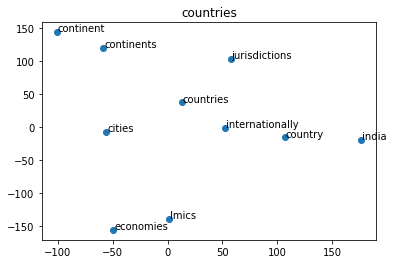

In [18]:
similarity('countries')

[('diabetes', 1.0000001), ('hypertension', 0.85157704), ('hyperlipidemia', 0.83561856), ('dyslipidemia', 0.83268374), ('mellitus', 0.78845227), ('dm', 0.7805076), ('obesity', 0.7793772), ('cvd', 0.7349323), ('dementia', 0.7090972), ('malignancy', 0.70476776)] 



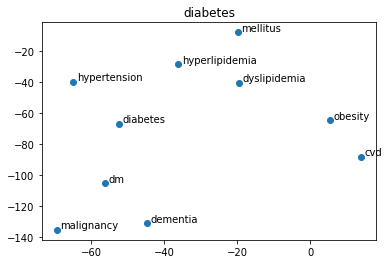

In [21]:
similarity('diabetes')

[('quarantine', 1.0), ('selfquarantine', 0.857819), ('selfisolation', 0.8010673), ('lockdown', 0.68769443), ('enforce', 0.6605507), ('lift', 0.64500546), ('lockdowns', 0.64287144), ('contact', 0.63174254), ('selfisolate', 0.61395717), ('impose', 0.6039114)] 



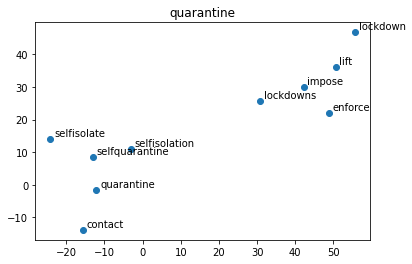

In [ ]:
similarity('quarantine')

[('april', 0.9999999), ('november', 0.89998174), ('march', 0.8490603), ('june', 0.84093416), ('july', 0.8358086), ('august', 0.81891257), ('october', 0.80403084), ('september', 0.7953353), ('post', 0.7577005), ('doi', 0.72218066)] 



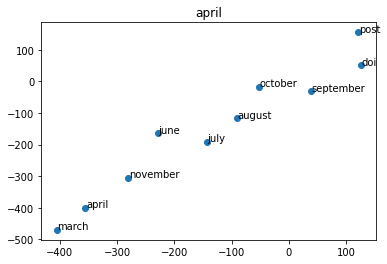

In [24]:
similarity('april')